In [43]:
# data downoaded from https://grouplens.org/datasets/movielens/latest/
DO_GRID_SEARCH = False

In [44]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, ArrayType

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [45]:
spark = SparkSession \
    .builder \
    .appName("recommendations") \
    .getOrCreate()
sc = spark.sparkContext


In [46]:
data_path = '../../data/recommendations/ml-latest-small/'
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

In [47]:
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [48]:
ratings.show(3)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
+------+-------+------+---------+
only showing top 3 rows



In [49]:
links.show(3)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
+-------+------+------+
only showing top 3 rows



In [50]:
tags.show(3)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
+------+-------+---------------+----------+
only showing top 3 rows



In [51]:
print('Distinct values of ratings:')
ratings.toPandas()['rating'].value_counts().sort_index()

Distinct values of ratings:


0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

In [52]:
# What is minimum number of ratings per user and minimum number of ratings per movie?

ratings_per_user = ratings.groupBy("userID").count().toPandas()['count'].min()
ratings_per_movie = ratings.groupBy("movieId").count().toPandas()['count'].min()
print(f"Minimum number of ratings per user is {ratings_per_user}")
print(f"Minimum number of ratings per movie is {ratings_per_movie}")

Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [53]:
# stats

movie_count = movies.select('movieId').distinct().count()
user_count = ratings.select('userID').distinct().count()
rated_movie_count = ratings.select('movieId').distinct().count()


print(f"{user_count} distinct users")
print(f"{movie_count} distinct movies")
print(f"{rated_movie_count} distinct rated movies")
print(f"{movie_count - rated_movie_count} unrated movies")


610 distinct users
9742 distinct movies
9724 distinct rated movies
18 unrated movies


In [54]:
# How many movies are rated by only one user?

rated_by_one = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)

print(f"{rated_by_one} / {movie_count} movies are rated by only one user")

3446 / 9742 movies are rated by only one user


In [55]:
# all movie genres
# define a udf for splitting the genres string
splitter = F.udf(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(F.explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



In [56]:
# Find out the number of movies for each category

print('Counts of movies per genre')
movies.select('movieID', F.explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(F.desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



In [57]:
# get rating frequency
df_movies_cnt = pd.DataFrame(ratings.toPandas().groupby('movieId').size(), columns=['count'])

Text(0, 0.5, 'number of ratings')

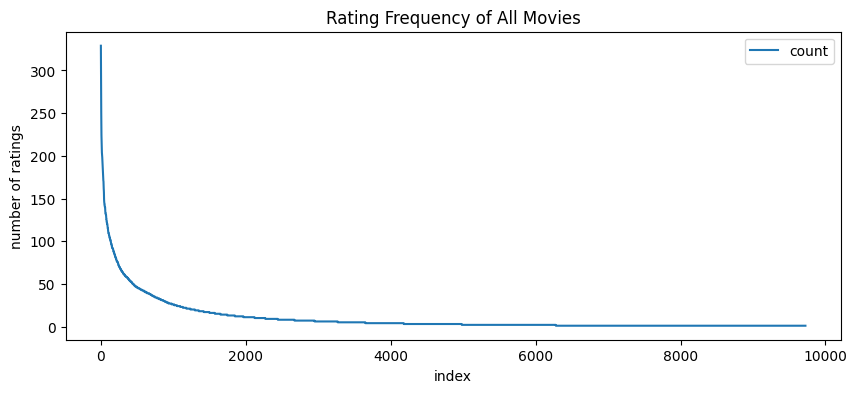

In [58]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(10, 4),
        title='Rating Frequency of All Movies',
        fontsize=10
    )
ax.set_xlabel("index")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

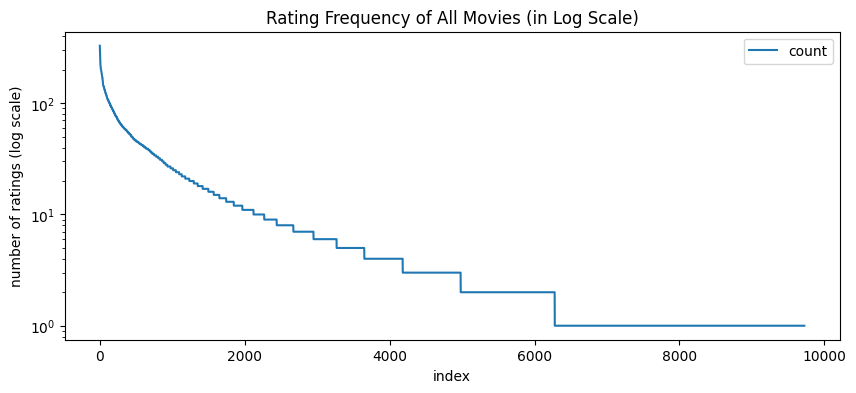

In [59]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(10, 4),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=10,
        logy=True
    )
ax.set_xlabel("index")
ax.set_ylabel("number of ratings (log scale)")

In [60]:
df_movies_cnt['count'].quantile(np.arange(1, 0.45, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
0.60      4.0
0.55      3.0
0.50      3.0
Name: count, dtype: float64

In [61]:
# prepare data for training
rating_data = ratings.select(["userId", "movieId", "rating"])
rating_data.printSchema()
rating_data.head(1)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



[Row(userId=1, movieId=1, rating=4.0)]

In [62]:
# split the data into training/validation/testing sets
train, validation, test = rating_data.randomSplit([6.0, 2.0, 2.0], seed=0)
train.cache()
validation.cache()
test.cache()

23/10/02 14:09:27 WARN CacheManager: Asked to cache already cached data.
23/10/02 14:09:27 WARN CacheManager: Asked to cache already cached data.
23/10/02 14:09:27 WARN CacheManager: Asked to cache already cached data.


DataFrame[userId: int, movieId: int, rating: double]

In [63]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

if DO_GRID_SEARCH:
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [8, 10, 12, 14, 16, 18, 20]) \
        .addGrid(als.maxIter, [10, 10, 10, 10, 10]) \
        .addGrid(als.regParam, [0.001, 0.01, 0.05, 0.1, 0.2]) \
        .build()

    # Tell Spark how to evaluate model performance
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    # Build cross validation step using CrossValidator
    cv = CrossValidator(estimator = als,
        estimatorParamMaps = param_grid,
        evaluator = evaluator,
        numFolds = 5)
    # Run the cv on the training data
    model = cv.fit(train)
    # Extract best combination of values from cross validation
    best_model = model.bestModel
    print(best_model)

In [64]:
als = ALS(
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating", 
    coldStartStrategy="drop", 
    nonnegative = True, 
    implicitPrefs = False,
    rank=12,
    maxIter=10,
    regParam=0.1)

model = als.fit(train)

In [65]:
predictions = model.transform(test)
predictions.show(3)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   580|   1580|   4.0|  3.201551|
|   580|  44022|   3.5| 3.6670213|
|   362|   1591|   4.0| 2.3161492|
+------+-------+------+----------+
only showing top 3 rows



In [66]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9042956249281511

In [68]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = evaluator.evaluate(predictions)
mae

0.6987187149311054

In [73]:
# What if this was treated more like a classification problem
# where a rating of >= 3.0 is considered a like and a rating of 
# < 3.0 is considered a dislike
# 1st attempt still using ALS for regression

binary_rating_data = rating_data.select("*")
binary_rating_data = binary_rating_data.withColumn("rating", 
                              F.when(binary_rating_data.rating >= 3.0, 5.0) \
                              .otherwise(0.0)
                             )
binary_train, binary_validation, binary_test = binary_rating_data.randomSplit([6.0, 2.0, 2.0], seed=0)
binary_train.cache()
binary_validation.cache()
binary_test.cache()

als = ALS(
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating", 
    coldStartStrategy="drop", 
    nonnegative = True, 
    implicitPrefs = False,
    rank=12,
    maxIter=10,
    regParam=0.1)

model = als.fit(binary_train)
predictions = model.transform(binary_test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"rmse: {rmse}")

evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = evaluator.evaluate(predictions)
print(f"mae: {mae}")


rmse: 1.9055634360597695
mae: 1.366315924440406
